# Deep EDA - Multi-Role & Market Dynamics

Following the preliminary cleaning, this notebook dives into the **Market Demand** and **Role Distribution**.

**Key Insight:** Instead of dropping duplicate IDs, we use them to understand how jobs are multi-classified in the market.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 100)

## 1. Load Cleaned Model Case

We reload the data from `all_jobs_merged.csv`. Note that we are starting with the version that includes multi-row entries for single job IDs.

In [2]:
df = pd.read_csv("../data/interim/all_jobs_merged.csv")
df['created'] = pd.to_datetime(df['created'])
df['company'] = df['company'].fillna('Unknown')
print(f"Loaded Shape: {df.shape}")
print(f"Unique job postings: {df['id'].nunique()}")

Loaded Shape: (39844, 9)
Unique job postings: 28025


## 2. Multi-Role Mapping

To assign various roles to the same ID, we group the data and aggregate the `search_term` values.

In [3]:
role_map = df.groupby('id')['search_term'].apply(lambda x: sorted(list(set(x.dropna())))).reset_index()
role_map.columns = ['id', 'matched_roles']
role_map['role_count'] = role_map['matched_roles'].apply(len)

print("Distribution of roles per job ID:")
print(role_map['role_count'].value_counts().sort_index())

role_map.head()

Distribution of roles per job ID:
role_count
1    22279
2     4366
3     1195
4      165
5       19
6        1
Name: count, dtype: int64


,id,matched_roles,role_count
0,5560990454,[Data],1
1,5560990728,[Data],1
2,5561033409,[Data Analyst],1
3,5561043862,[Data Analyst],1
4,5561048338,[Data Analyst],1


## 3. Merge Flattened Roles back to Unique Jobs

We create a deduplicated dataframe where each row is a unique job, but now contains the full list of matched roles.

In [4]:
df_unique = df.drop_duplicates(subset=['id']).copy()
df_unique = df_unique.merge(role_map, on='id', how='left')

print(f"Deduplicated Shape: {df_unique.shape}")
df_unique[['title', 'company', 'matched_roles', 'role_count']].head()

Deduplicated Shape: (28025, 11)


,title,company,matched_roles,role_count
0,Data Analyst (Growth),Jobgether,"[Data, Data Analyst]",2
1,Product Owner - Data & Analytics (f/m/d),Greentube GmbH,"[Data, Data Analyst, Data Engineer, Data Scientist]",4
2,AI & Data Science Analyst (all genders),Accenture,"[Data, Data Analyst]",2
3,"Data Analyst & Engineer (m/w/d) Retail & Marketing, Umzug nach Tirol?",ANGEHEUERT GmbH Personalberatung,"[Data, Data Analyst, Data Engineer]",3
4,"Senior Data Analyst (m/w/d) Google Analytics 4, Looker Studio, Power BI, SQL",ANGEHEUERT GmbH Personalberatung,"[Data, Data Analyst]",2


## 4. Role Hierarchy Analysis

Which role combinations are the most common?

Total hybrid jobs (matching >1 segment): 5746


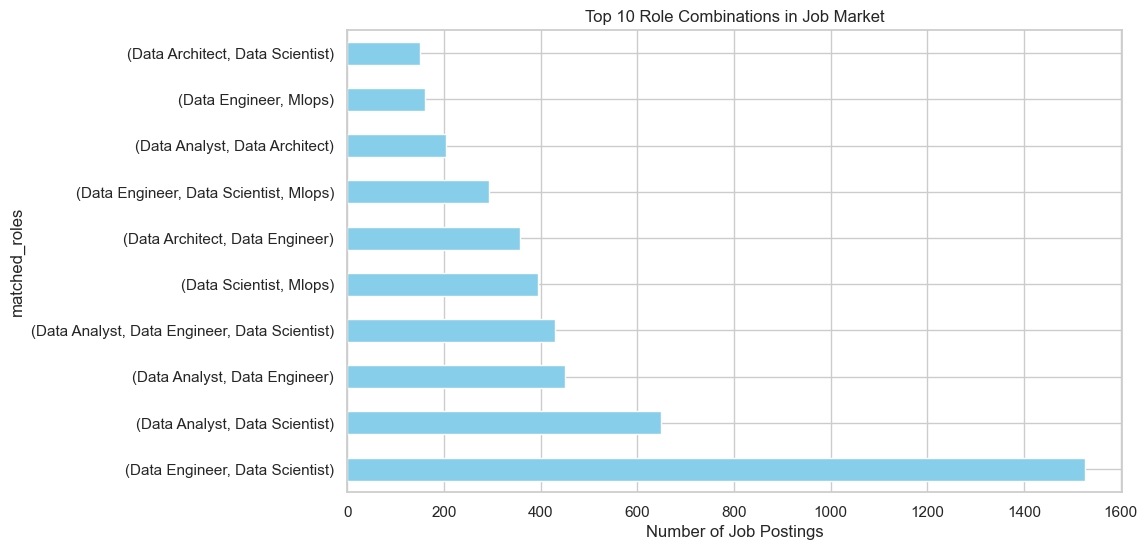

In [5]:
hybrid_roles = df_unique[df_unique['role_count'] > 1]
print(f"Total hybrid jobs (matching >1 segment): {len(hybrid_roles)}")

role_combinations = hybrid_roles['matched_roles'].apply(tuple).value_counts().head(10)
plt.figure(figsize=(10, 6))
role_combinations.plot(kind='barh', color='skyblue')
plt.title('Top 10 Role Combinations in Job Market')
plt.xlabel('Number of Job Postings')
plt.show()

## 5. Granular Role Classification

Beyond the `search_term`, we'll use title keywords to classify jobs into more standard industry buckets. This handles the 'Data' search term which is too broad.

C:\Users\bnove\AppData\Local\Temp\ipykernel_16164\1708787798.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_dist.values, y=role_dist.index, palette='viridis')


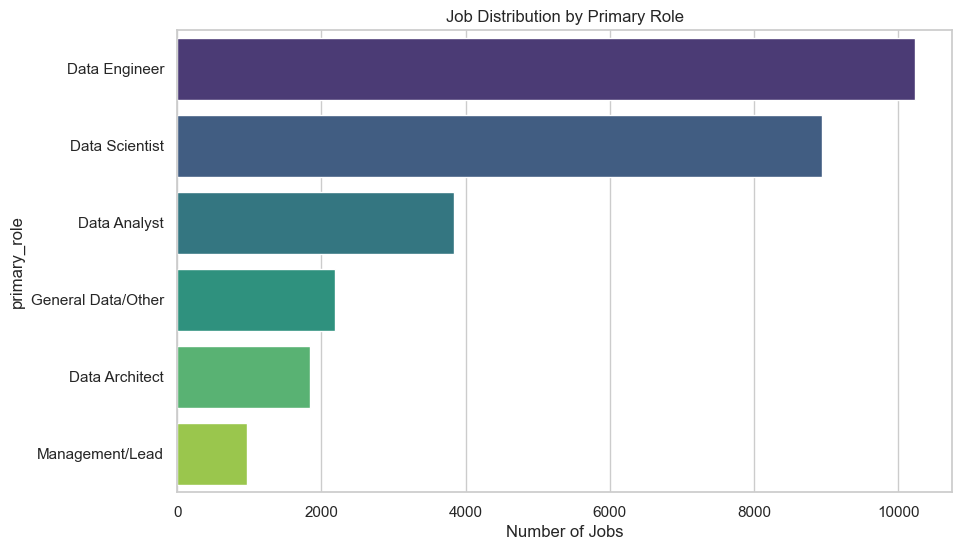

In [6]:
def classify_role(row):
    title = str(row['title']).lower()
    roles = row['matched_roles']
    
    if 'scientist' in title or 'science' in title or 'Data Scientist' in roles:
        return 'Data Scientist'
    if 'engineer' in title or 'engineering' in title or 'Data Engineer' in roles or 'Mlops' in roles:
        return 'Data Engineer'
    if 'analyst' in title or 'analytics' in title or 'Data Analyst' in roles:
        return 'Data Analyst'
    if 'architect' in title or 'Data Architect' in roles:
        return 'Data Architect'
    if 'lead' in title or 'manager' in title or 'head' in title or 'director' in title:
        return 'Management/Lead'
    
    return 'General Data/Other'

df_unique['primary_role'] = df_unique.apply(classify_role, axis=1)
role_dist = df_unique['primary_role'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=role_dist.values, y=role_dist.index, palette='viridis')
plt.title('Job Distribution by Primary Role')
plt.xlabel('Number of Jobs')
plt.show()

## 6. Geographical Insights

Where are the jobs?

C:\Users\bnove\AppData\Local\Temp\ipykernel_16164\1810678768.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_jobs.index, y=country_jobs.values, palette='magma')


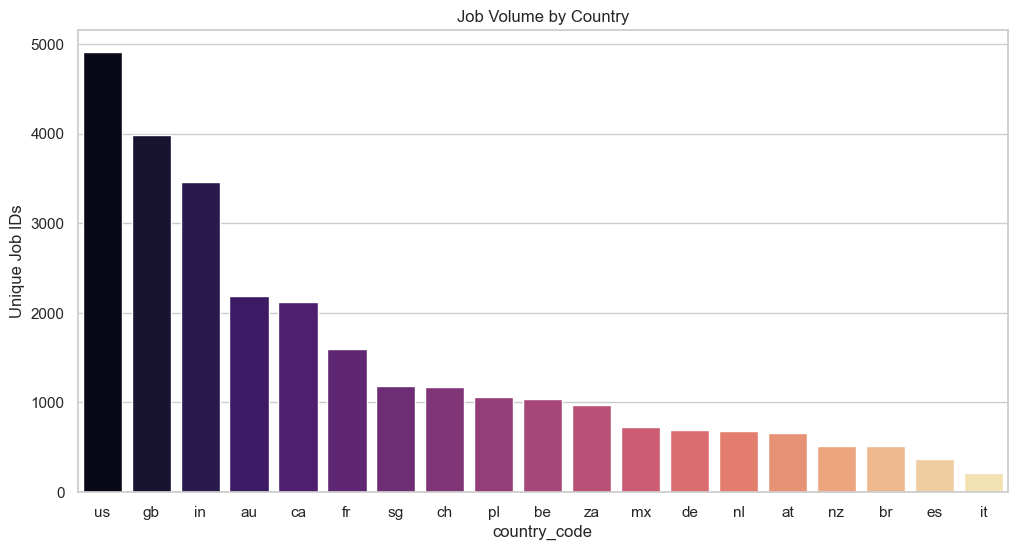

Top 5 Countries by Job Volume:
country_code
us    4910
gb    3988
in    3455
au    2183
ca    2123
Name: count, dtype: int64


In [7]:
country_jobs = df_unique['country_code'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=country_jobs.index, y=country_jobs.values, palette='magma')
plt.title('Job Volume by Country')
plt.ylabel('Unique Job IDs')
plt.show()

print("Top 5 Countries by Job Volume:")
print(country_jobs.head())

## 7. Company Concentration

Who is hiring the most? (Excluding 'Unknown')

C:\Users\bnove\AppData\Local\Temp\ipykernel_16164\1348764376.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette='rocket')


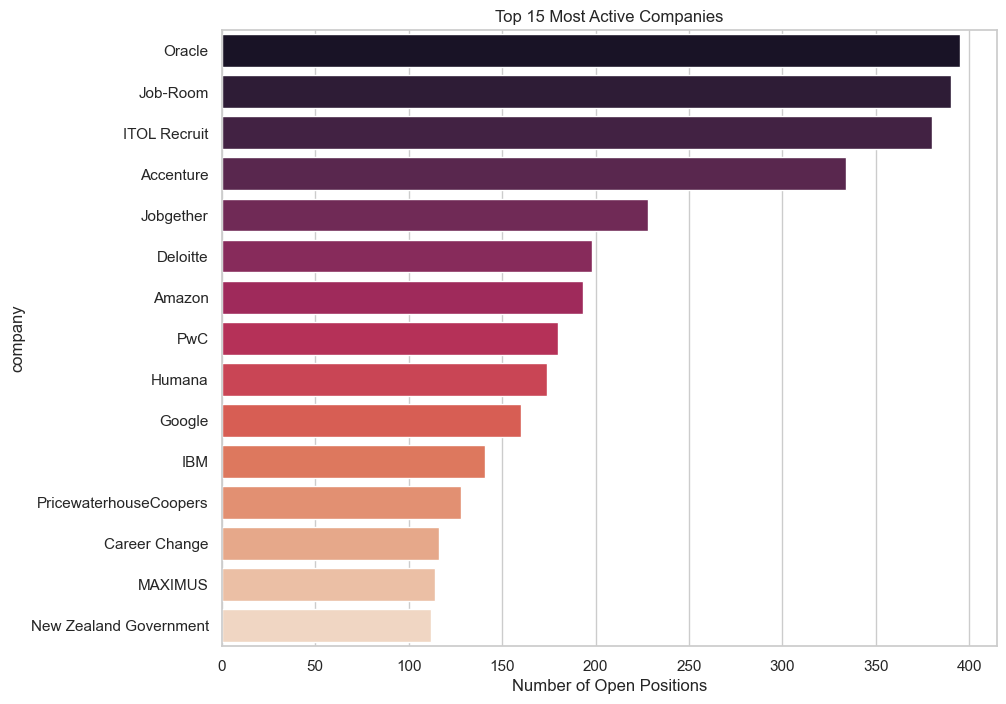

In [8]:
top_companies = df_unique[df_unique['company'] != 'Unknown']['company'].value_counts().head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_companies.values, y=top_companies.index, palette='rocket')
plt.title('Top 15 Most Active Companies')
plt.xlabel('Number of Open Positions')
plt.show()

## 8. Temporal Trends

Are there specific days with more activity?

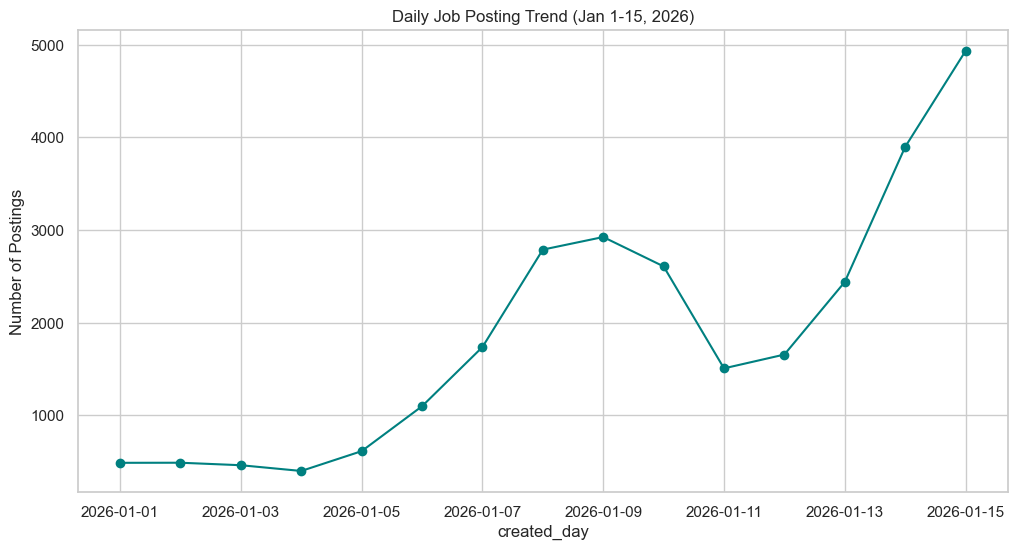

In [9]:
df_unique['created_day'] = df_unique['created'].dt.date
daily_jobs = df_unique.groupby('created_day').size()

plt.figure(figsize=(12, 6))
daily_jobs.plot(kind='line', marker='o', color='teal')
plt.title('Daily Job Posting Trend (Jan 1-15, 2026)')
plt.ylabel('Number of Postings')
plt.grid(True)
plt.show()

## Final Observations

1. **Market Dominance:** Job volume is heavily concentrated in the US and GB.
2. **Role Profile:** Data Engineers and Analysts comprise the bulk of the opportunities.
3. **Company Landscape:** Even with many 'Unknowns', top players in consulting and tech show high recurring volume.
4. **Multi-Role Nature:** A significant portion of 'Data' search results are actually specialized roles, justifying our mapping strategy.